### 1. first I need to read the image of numbers.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

In [2]:
image_path = r"C:\Users\livid\Documents\GitHub\kaggle_data\digit-recognizer\number_picture.jpg"
original_image = Image.open(image_path)
image_np = np.array(original_image)

In [3]:
print(type(original_image))
print(type(image_np))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>


In [4]:
print(f'The size is {image_np.shape}')
print(f"pixel type{image_np.dtype}")

The size is (1188, 2328, 3)
pixel typeuint8


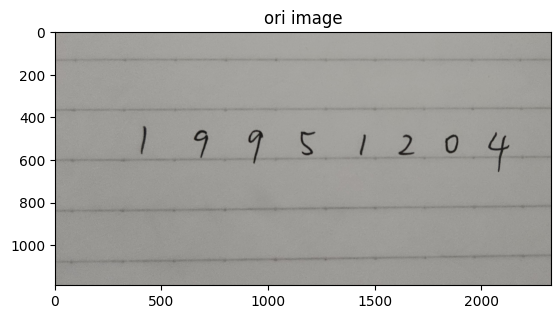

In [5]:
plt.imshow(image_np)
plt.title("ori image")
plt.show()

### 2. Split the image to 8 sub arrays for machine learning

In [6]:
image_height = image_np.shape[0]
image_width = image_np.shape[1]
top_padding = 400
tottom_padding = 500
left_padding = 300
right_padding = 130
cropped_image = image_np[top_padding : image_height - tottom_padding,
                            left_padding : image_width - right_padding]

print(f"the size of cropped image is {cropped_image.shape}")
cropped_height = cropped_image.shape[0]
cropped_width = cropped_image.shape[1]
num_digits = 8

digit_width = cropped_width // num_digits
digit_width

the size of cropped image is (288, 1898, 3)


237

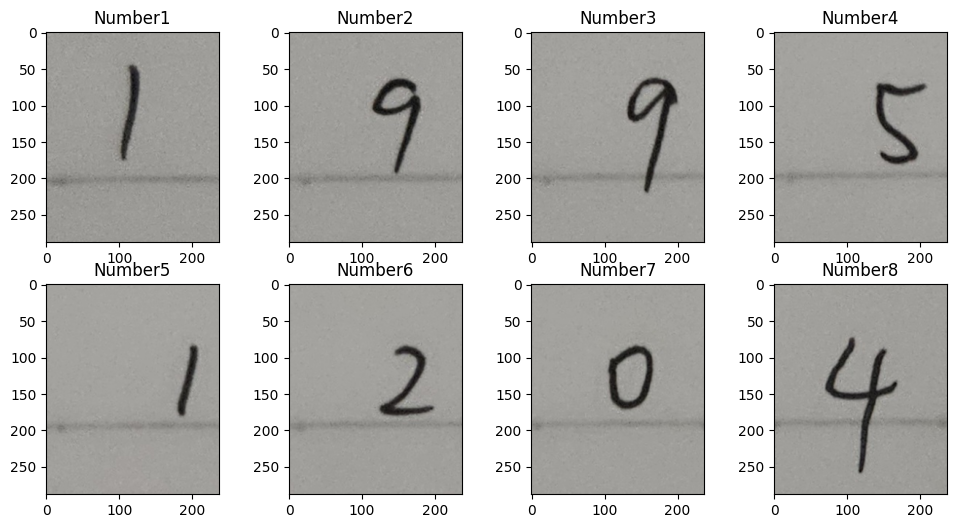

In [7]:
digit_images = []
for i in range(num_digits):
    start_col = i * digit_width
    end_col = (i + 1) * digit_width
    digit = cropped_image[:, start_col:end_col]
    digit_images.append(digit)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(digit_images[i])
    ax.set_title(f"Number{i+1}")

plt.tight_layout
plt.show()

--- 最终优化处理结果 V3 (已处理孔洞) ---


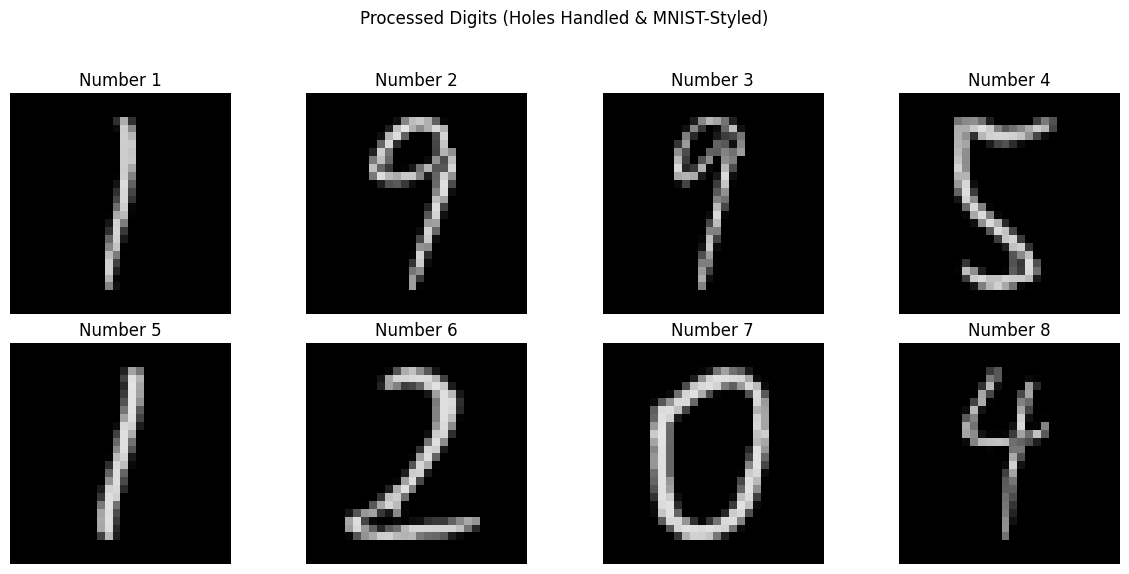

In [8]:
# 1. 定义最终版本的核心处理函数（带孔洞处理）
def process_digit_final_v3(img_bgr, canvas_size=28, digit_size=22, target_brightness=240):
    """
    终极版V3：移除格子线，精确处理孔洞(如0, 8, 9)，并格式化为MNIST风格。
    """
    gray_image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # --- 步骤1: 移除横向格子线 ---
    kernel = np.ones((15, 1), np.uint8)
    grid_lines_removed_img = cv2.morphologyEx(gray_image, cv2.MORPH_OPEN, kernel)

    # --- 步骤2: 自适应阈值 ---
    binary_img = cv2.adaptiveThreshold(
        grid_lines_removed_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 19, 5
    )

    # --- 关键步骤3: 使用轮廓层级(Contour Hierarchy)处理孔洞 ---
    # 使用 RETR_CCOMP 获取轮廓及其层级关系
    contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return np.zeros((canvas_size, canvas_size), dtype=np.uint8)

    # hierarchy[0][i] = [Next, Previous, First_Child, Parent]
    # 我们要找最大的外层轮廓（其Parent为-1）
    max_area = 0
    main_contour_idx = -1
    for i in range(len(contours)):
        # 如果 parent 是 -1, 说明这是一个外层轮廓
        if hierarchy[0][i][3] == -1:
            area = cv2.contourArea(contours[i])
            if area > max_area:
                max_area = area
                main_contour_idx = i
    
    # 如果没有找到有效的外层轮廓
    if main_contour_idx == -1:
        return np.zeros((canvas_size, canvas_size), dtype=np.uint8)

    # --- 关键步骤4: 创建一个能正确表示孔洞的精确遮罩 ---
    mask = np.zeros_like(gray_image)
    # 1. 先用白色填充整个外层轮廓
    cv2.drawContours(mask, contours, main_contour_idx, (255), thickness=cv2.FILLED)
    
    # 2. 再用黑色把属于该外层轮廓的内层孔洞“冲压”出来
    for i in range(len(contours)):
        # 如果轮廓的 parent 是我们的主轮廓，说明它是一个孔洞
        if hierarchy[0][i][3] == main_contour_idx:
            cv2.drawContours(mask, contours, i, (0), thickness=cv2.FILLED)

    # --- 步骤5: 从原始灰度图（反色）中提取数字 ---
    inverted_original = cv2.bitwise_not(grid_lines_removed_img)
    extracted_digit = cv2.bitwise_and(inverted_original, inverted_original, mask=mask)
    
    x, y, w, h = cv2.boundingRect(contours[main_contour_idx])
    digit_roi = extracted_digit[y:y+h, x:x+w]
    
    # --- 步骤6: 对比度拉伸 ---
    current_max = np.max(digit_roi)
    if current_max > 50:
        scale = target_brightness / current_max
        digit_roi = np.clip((digit_roi * scale), 0, 255).astype(np.uint8)
    
    # --- 步骤7: 调整大小并居中 ---
    h_roi, w_roi = digit_roi.shape
    if w_roi > h_roi: new_w, new_h = digit_size, int(digit_size * h_roi / w_roi)
    else: new_h, new_w = digit_size, int(digit_size * w_roi / h_roi)
    if new_w == 0 or new_h == 0: return np.zeros((canvas_size, canvas_size), dtype=np.uint8)
        
    resized_digit = cv2.resize(digit_roi, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    canvas = np.zeros((canvas_size, canvas_size), dtype=np.uint8)
    x_offset, y_offset = (canvas_size - new_w) // 2, (canvas_size - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_digit
    
    return canvas

# 2. 循环处理所有分割出的数字图像
final_processed_pixels = []
for image in digit_images:
    processed_img_array = process_digit_final_v3(image)
    final_processed_pixels.append(processed_img_array.flatten())

# 3. 创建最终的DataFrame
column_names = [f'pixel{i}' for i in range(784)]
processed_data = pd.DataFrame(final_processed_pixels, columns=column_names)

# 4. 可视化检查处理效果
print("--- 最终优化处理结果 V3 (已处理孔洞) ---")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Processed Digits (Holes Handled & MNIST-Styled)')

for i, ax in enumerate(axes.flat):
    if i < len(processed_data):
        image_data = processed_data.iloc[i].to_numpy().reshape(28, 28)
        ax.imshow(image_data, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f"Number {i+1}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
processed_data.iloc[0].shape

(784,)

In [10]:
DATA_PATH = "../../kaggle_data/digit-recognizer/"
train_data = pd.read_csv(DATA_PATH+"train.csv")

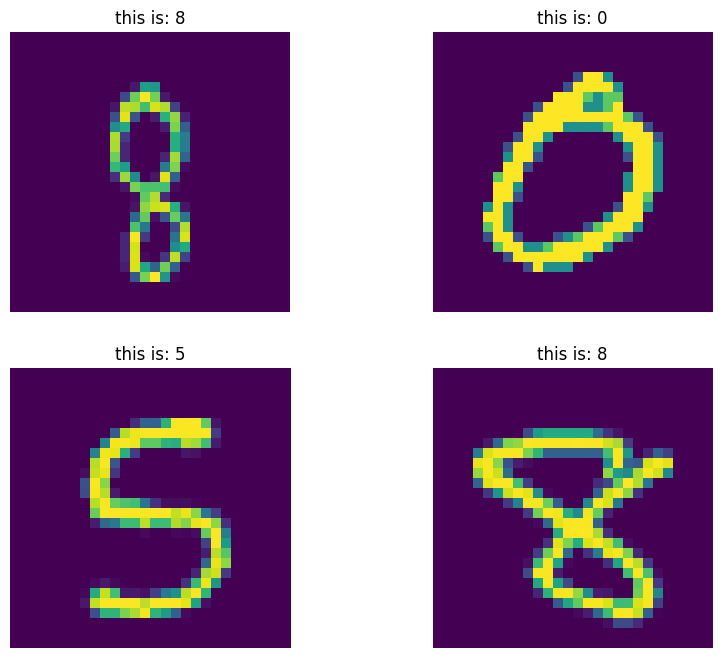

In [11]:
import random

plt.figure(figsize=(10, 8))
for i in range(4):
    random_index = random.randint(0, len(train_data) - 1)
    image_data = train_data.iloc[random_index, 1:].to_numpy().reshape(28, 28)
    label = train_data.iloc[random_index, 0]
    
    plt.subplot(2, 2, i+1)
    plt.imshow(image_data)
    plt.title(f'this is: {label}')
    plt.axis('off')

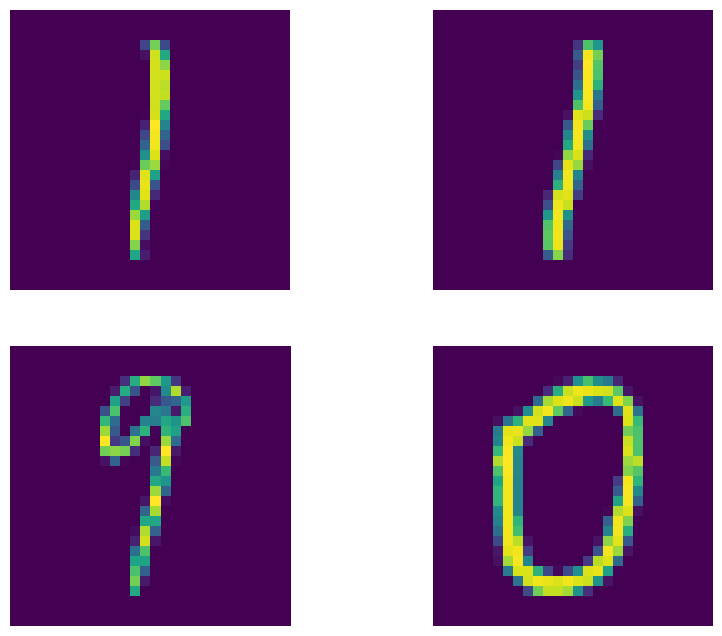

In [12]:
import random

plt.figure(figsize=(10, 8))
for i in range(4):
    random_index = random.randint(0, len(processed_data) - 1)
    image_data = processed_data.iloc[random_index, ].to_numpy().reshape(28, 28)
    plt.subplot(2, 2, i+1)
    plt.imshow(image_data)
    plt.axis('off')

In [13]:
X = train_data.drop(['label'],axis=1) / 255.0
y = train_data['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [14]:
y_train_enc = tf.keras.utils.to_categorical(y_train)
y_valid_enc = tf.keras.utils.to_categorical(y_valid)

In [15]:
y_train_enc.shape

(33600, 10)

In [16]:
X_train = X_train.values.reshape(-1,28,28,1)
X_valid = X_valid.values.reshape(-1,28,28,1)

In [17]:
X_valid.shape

(8400, 28, 28, 1)

In [18]:
def model():
    nn = tf.keras.models.Sequential()
    nn.add(Conv2D(64, kernel_size=(3,3), kernel_initializer='he_normal', input_shape=(28,28,1), activation='relu'))
    nn.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
    nn.add(MaxPooling2D(pool_size=(2,2)))
    nn.add(BatchNormalization())
    nn.add(Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
    nn.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    nn.add(MaxPooling2D(pool_size=(2,2)))
    nn.add(Dropout(0.2))
    nn.add(Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
    nn.add(MaxPooling2D(pool_size=(2,2)))
    nn.add(Flatten())
    nn.add(Dense(2048, activation='relu'))
    nn.add(Dense(10, activation='softmax'))

    nn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return nn

In [19]:
model = model()
model.summary()

c:\Users\livid\miniconda3\envs\kaggle\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       526,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101,258 (4.20 MB)

 Trainable params: 1,101,130 (4.20 MB)

 Non-trainable params: 128 (512.00 B)

In [20]:
model.fit(X_train, y_train_enc, batch_size=5, epochs=2)

Epoch 1/2
6720/6720 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - accuracy: 0.8899 - loss: 0.3836
Epoch 2/2
6720/6720 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - accuracy: 0.9687 - loss: 0.1178


In [21]:
loss, acc = model.evaluate(X_valid, y_valid_enc)

263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9759 - loss: 0.0964


In [22]:
processed_data_normalized = processed_data / 255.0
pred = model.predict(processed_data_normalized.values.reshape(-1, 28, 28, 1))
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


(8, 10)

In [23]:
preds = []
for i in range(8):
    preds.append(np.argmax(pred[i]))

In [24]:
preds

[np.int64(1),
 np.int64(9),
 np.int64(9),
 np.int64(5),
 np.int64(1),
 np.int64(2),
 np.int64(0),
 np.int64(4)]

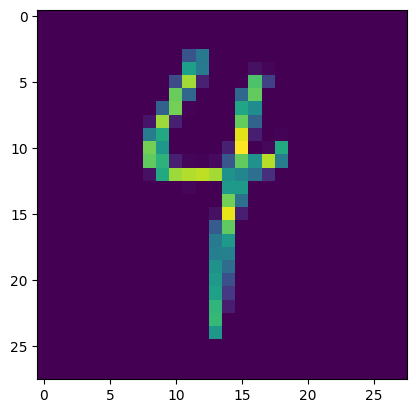

In [25]:
plt.imshow(processed_data.iloc[7].values.reshape(28, 28))